In [1]:
%config InlineBackend.figure_format = 'svg'

In [62]:
import arviz as az
import astropy.io.ascii as aio
import celerite2
import celerite2.theano
from celerite2.theano import terms as theano_terms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import pymc3_ext as pmx
import scipy.stats as ss
import seaborn as sns
import theano
import theano.tensor as T

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

Here are some sensible parameters for Aldebaran:

In [3]:
mu_Hz_day = 1/(24.0*3600.0)*1e6

In [4]:
A_sun = 0.2 # m/s
Laldeb = 439 # LSun
Maldeb = 1.16 # MSun
Taldeb = 3900 # K
TSun = 5800 # K

A_aldeb_scaling = Laldeb / (Maldeb**1.5*(Taldeb/TSun)**2.25)
A_aldeb = 60.0 # 170 m/s is the RMS amplitude from Farr+(2018), but who knows how many modes it contains....
A_aldeb_scaling, A_aldeb

(858.21313294463, 60.0)

In [5]:
numax_aldeb = 2.33 # muHz
Dnu_sun = 135.0 # muHz
Dnu_aldeb = (Maldeb)**0.5*(Taldeb/TSun)**3/(Laldeb)**0.75*Dnu_sun
dnu_aldeb = 0.12*Dnu_aldeb
(numax_aldeb, Dnu_aldeb, dnu_aldeb)

(2.33, 0.4609185779612971, 0.05531022935535565)

A few properties of the oscillations:

In [6]:
print('Numax period: {:.1f} d'.format(mu_Hz_day/numax_aldeb))
print('Dnu_period: {:.1f} d'.format(mu_Hz_day/Dnu_aldeb))
print('dnu_period: {:.1f} d'.format(mu_Hz_day/dnu_aldeb))

Numax period: 5.0 d
Dnu_period: 25.1 d
dnu_period: 209.3 d


We need to be careful, because there aren't all that many large spacings that can fit into the frequencies smaller than $\nu_\mathrm{max}$:

In [7]:
numax_aldeb / Dnu_aldeb

5.055122773106464

In [8]:
Nmode = 5

bw = (Dnu_aldeb + dnu_aldeb)*Nmode*1.5
print('Total Bandwidth (plus padding) is {:.1f} muHz, or a sample rate of {:.1f} / d'.format(bw, bw/mu_Hz_day))

Amode_total = 170
fmodes = np.array([numax_aldeb - (i-Nmode//2)*Dnu_aldeb for i in range(Nmode)])
fmodes = np.sort(np.concatenate((fmodes, fmodes + dnu_aldeb)))
Amodes = np.exp(-0.5*np.square((fmodes - numax_aldeb)/Dnu_aldeb)) # Falloff with width Dnu_aldeb
Amodes = Amodes * 170 / np.sqrt(np.sum(np.square(Amodes)))
Q_true = 2*numax_aldeb / dnu_aldeb

kernel_true = np.sum([celerite2.terms.SHOTerm(sigma=A, Q=Q_true, w0=2*np.pi*f/(mu_Hz_day)) for (A, f) in zip(Amodes, fmodes)])
gp_true = celerite2.GaussianProcess(kernel_true)

Total Bandwidth (plus padding) is 3.9 muHz, or a sample rate of 0.3 / d


We imagine that we observe once a week for a year, +/- 2 days, with uncertainty that is 2.5 +/- 0.5 m/s (comparable to Song).  For whatever reason, 25% of the measurements are dropped (bad week, whatever).

In [53]:
t_obs = np.arange(0, 2/(dnu_aldeb/mu_Hz_day), 1/(2*bw/mu_Hz_day))
dt_obs = t_obs[1]-t_obs[0]
t_obs = t_obs + np.random.uniform(low=-0.25*dt_obs, high=0.25*dt_obs, size=len(t_obs))
t_obs = t_obs[np.random.rand(len(t_obs)) > 0.25]

# Set to 1 to replicate the actual Song observations:
sigma_factor = 1.0
sigma_obs = sigma_factor*(2.5 + np.random.uniform(low=-0.5, high=0.5, size=len(t_obs)))

In [54]:
f_resol = (1/(np.max(t_obs) - np.min(t_obs)))*mu_Hz_day
bw = len(t_obs)*f_resol/2

print('bw / Dnu_aldeb = {:.1f}'.format(bw/Dnu_aldeb))

bw / Dnu_aldeb = 2.8


<ErrorbarContainer object of 3 artists>

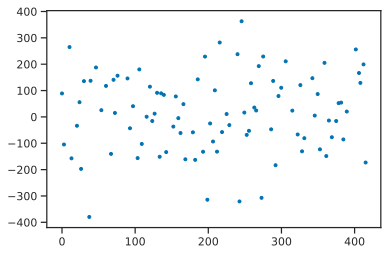

In [55]:
gp_true.compute(t_obs, yerr=sigma_obs)
rv_obs = gp_true.sample()

plt.errorbar(t_obs, rv_obs, yerr=sigma_obs, fmt='.')

Here is the true PSD:

Text(0, 0.5, '$P(f) / \\mathrm{m}^2 \\, \\mathrm{s}^{-2} \\, \\mu\\mathrm{Hz}^{-1}$')

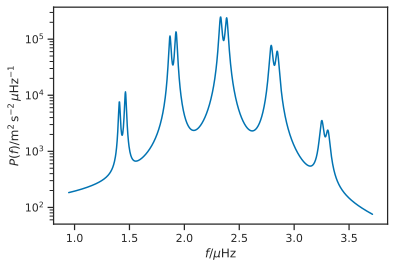

In [56]:
fs = np.linspace(numax_aldeb - (Nmode//2 + 1)*Dnu_aldeb, numax_aldeb + (Nmode//2 + 1)*Dnu_aldeb, 1024)
psd_true = gp_true.kernel.get_psd(2*np.pi*fs/mu_Hz_day)*2*np.pi/mu_Hz_day

plt.plot(fs, psd_true)
plt.yscale('log')
plt.xlabel(r'$f / \mu\mathrm{Hz}$')
plt.ylabel(r'$P(f) / \mathrm{m}^2 \, \mathrm{s}^{-2} \, \mu\mathrm{Hz}^{-1}$')

Let's build a model!

In [63]:
t_pred = np.linspace(np.min(t_obs), np.max(t_obs), 1024)
with pm.Model() as model_aldeb:
    fcent = pm.Bound(pm.Normal, lower=numax_aldeb-0.5*Dnu_aldeb, upper=numax_aldeb+0.5*Dnu_aldeb)('fcent', mu=numax_aldeb + Dnu_aldeb/10, sigma=0.25*Dnu_aldeb)

    Amax = pm.Lognormal('Amax', mu=np.log(100), sigma=1)
    fmax = pm.Lognormal('fmax', mu=np.log(numax_aldeb), sigma=1)
    sigma = pm.Lognormal('sigma', mu=np.log(1), sigma=1)
    
    Q = pm.Lognormal('Q', mu=np.log(Q_true), sigma=1)
    
    Df = pm.Bound(pm.Normal, lower=Dnu_aldeb/2, upper=Dnu_aldeb*2)('Df', mu=Dnu_aldeb + Dnu_aldeb/10, sigma=Dnu_aldeb/4)
    df = pm.Bound(pm.Normal, lower=dnu_aldeb/2, upper=dnu_aldeb*2)('df', mu=dnu_aldeb - dnu_aldeb/10, sigma=dnu_aldeb/4)
    
    freqs1 = [fcent + (i-Nmode//2)*Df for i in range(Nmode)]
    freqs2 = [fcent + (i-Nmode//2)*Df + df for i in range(Nmode)]
    freqs = pm.Deterministic('freqs', T.as_tensor(freqs1+freqs2))

    As = Amax*T.exp(-T.square((freqs - fmax)/(sigma*Df))/2)
    
    terms = [theano_terms.SHOTerm(sigma=As[i], Q=Q, w0=2*np.pi*freqs[i]/mu_Hz_day) for i in range(2*Nmode)]
    
    k = theano_terms.TermSum(*terms)
    gp = celerite2.theano.GaussianProcess(k)
    
    gp.compute(t_obs, yerr=sigma_obs)
    gp.marginal('rv_obs', observed=rv_obs)
    
    resid = pm.Deterministic('residual', rv_obs - gp.predict(rv_obs, t=t_obs))
    psd = pm.Deterministic('PSD', gp.kernel.get_psd(2*np.pi*fs/mu_Hz_day)*2*np.pi/mu_Hz_day)
    rv_pred = pm.Deterministic('rv_pred', gp.predict(rv_obs, t=t_pred))

In [64]:
n = 4
with model_aldeb:
    trace = pm.sample(tune=n*1000, draws=n*1000, step=pm.DEMetropolisZ())
trace = trace[::n]
with model_aldeb:
    s = pm.summary(trace)
s

/tmp/ipykernel_1110630/646734619.py:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=n*1000, draws=n*1000, step=pm.DEMetropolisZ())
Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [df, Df, Q, sigma, fmax, Amax, fcent]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 92 seconds.
The number of effective samples is smaller than 10% for some parameters.


mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
fcent            2.318   0.010    2.300    2.338      0.001    0.000   
Amax            73.675  11.785   53.549   95.645      0.607    0.430   
fmax             2.255   0.064    2.136    2.382      0.004    0.003   
sigma            1.113   0.139    0.877    1.399      0.007    0.005   
Q               80.054  27.099   34.244  128.883      1.533    1.104   
...                ...     ...      ...      ...        ...      ...   
rv_pred[1019]  110.075   8.324   95.292  126.555      0.321    0.227   
rv_pred[1020]   16.312   7.837    1.458   31.104      0.297    0.214   
rv_pred[1021]  -75.976   6.425  -88.765  -64.741      0.249    0.176   
rv_pred[1022] -144.415   3.933 -151.780 -136.968      0.159    0.112   
rv_pred[1023] -173.009   0.012 -173.031 -172.985      0.001    0.000   

               ess_bulk  ess_tail  r_hat  
fcent             409.0     734.0   1.01  
Amax              413.0     629.0   1.02  
fmax              230.0     293.0   1.02  
sigma             461.0     589.0   1.01  
Q                 342.0     394.0   1.01  
...                 ...       ...    ...  
rv_pred[1019]     678.0     933.0   1.00  
rv_pred[1020]     720.0     824.0   1.00  
rv_pred[1021]     696.0     690.0   1.01  
rv_pred[1022]     643.0     700.0   1.01  
rv_pred[1023]     545.0     782.0   1.01  

[2158 rows x 9 columns]

In [65]:
with model_aldeb:
    pm.plot_trace(trace, var_names=['fcent', 'freqs', 'Amax', 'fmax', 'sigma', 'Q', 'Df', 'df'],
                  lines=[('fcent', {}, numax_aldeb),
                         ('Amax', {}, np.max(Amodes)),
                         ('fmax', {}, fmodes[np.argmax(Amodes)]),
                         ('sigma', {}, 1),
                         ('Q', {}, Q_true),
                         ('Df', {}, Dnu_aldeb),
                         ('df', {}, dnu_aldeb)])

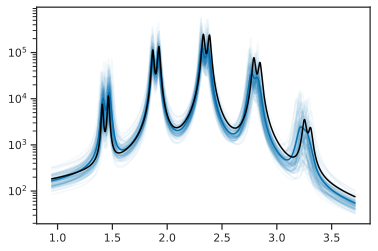

In [66]:
l, = plt.plot(fs, np.mean(trace['PSD'], axis=0))
for _ in range(100):
    i = np.random.randint(trace['PSD'].shape[0])
    plt.plot(fs, trace['PSD'][i,:], color=l.get_color(), alpha=0.05)
plt.plot(fs, gp_true.kernel.get_psd(2*np.pi*fs/mu_Hz_day)*2*np.pi/mu_Hz_day, color='k')
plt.yscale('log')

Text(0, 0.5, '$v_r - v_{r,\\mathrm{pred}} / \\mathrm{m} \\, \\mathrm{s}^{-1}$')

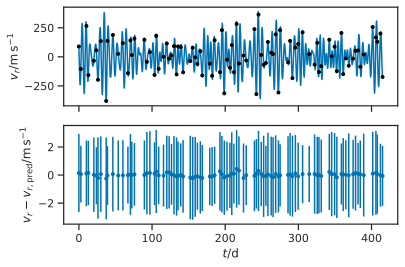

In [67]:
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, sharex=True)
ax1.errorbar(t_obs, rv_obs, yerr=sigma_obs, fmt='.', color='k')
ax1.plot(t_pred, trace['rv_pred'].mean(axis=0))
ax2.errorbar(t_obs, trace['residual'].mean(axis=0), yerr=sigma_obs, fmt='.')
ax2.set_xlabel(r'$t / \mathrm{d}$')
ax1.set_ylabel(r'$v_r / \mathrm{m} \, \mathrm{s}^{-1}$')
ax2.set_ylabel(r'$v_r - v_{r,\mathrm{pred}} / \mathrm{m} \, \mathrm{s}^{-1}$')

In [69]:
atrace = az.from_pymc3(trace, model=model_aldeb)
az.to_netcdf(atrace, '../data/mock_aldeb_trace.nc')

'../data/mock_aldeb_trace.nc'